                                                                  THE ADDING PROBLEM

CREATION OF DATASET --5000 datapoints

In [ ]:

import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
transform=transforms.ToTensor()


#since variable length arrays we will use lists of python
#each element of list is x data sample and it corresponding label
dataset=[]

#function for dataset creation
def datasetcreation(n,minlength):
  #max length is 12(if the n==5000) and min is 3(if minlength==3) 
  variablelengthlst=np.zeros(n,dtype=int)
  cnt=0
  val=minlength
  for i in range(0,n):
    cnt=cnt+1
    variablelengthlst[i]=int(val)
    if cnt>=n/10:
      cnt=0
      val=val+1

  np.random.shuffle(variablelengthlst)
  #print(variablelengthlst)


  for i in range(0,n):
    #length will be 2*i
    firstdim=torch.rand(1,variablelengthlst[i])
    seconddim=torch.zeros((1,variablelengthlst[i]))
    lst=[i for i in range(0,variablelengthlst[i])]

    #randomly initialisig the 2nd dimension's two elements to be 1
    np.random.shuffle(lst)
    seconddim[0][lst[0]]=1
    seconddim[0][lst[1]]=1
    concatenated=torch.cat((firstdim,seconddim),axis=0)
    #print(np.shape(concated))

    #label //label.item() is tensor free
    label=firstdim[0][lst[0]]+firstdim[0][lst[1]]

    dataset.append([concatenated,label])

#first argument is the no of datapoints and second is the min length of each input
datasetcreation(5000,3)
print("DEMOSTRATION")
print("dataset len",len(dataset))
print("shape of one data sample",np.shape(dataset[4999][0]))
print("label corresponding to that data sample",dataset[4999][1])

DEMOSTRATION
dataset len 5000
shape of one data sample torch.Size([2, 5])
label corresponding to that data sample tensor(1.8414)


Spliting Dataset into test and train 

In [ ]:
#split into test and train by shuffling
np.random.shuffle(dataset)
traindataset=dataset[0:2500]
testdataset=dataset[2500:]

ELMON NETWORK(1-layered ) Using the class notations..We need to handle the case of vanishing gradients(if any) as mentioned by sir in comments  "**you should be careful to make that part a constant which results in zero gradients**".The approch will be saimilar to resblocks. \\
Start with $h0 = 0$ \\
$h_t = tanh(W_{xh}.x_t + W_{hh}.h_{t−1} + b_h)$ \\
we will use final h to get the prediction \\
final prediction function is : $y=W_{yh}h_{final}+b_y$

In [ ]:
#EQuations h=tanh(WxhX+WhhH+bh)
#y=WhyH+by  no softmax bec this is not a classification problem but regression and output can have a value>1

#parameters constant through all time steps
#memory is of 10 dimensions
#not a parameter
#parametetrs

#len(dataset[0][0])==length of xt

elmon_h=torch.zeros(10)
elmon_Wxh=torch.rand(  ( len(elmon_h),len(dataset[0][0]) ) )
elmon_Whh=torch.rand( ( len(elmon_h),len(elmon_h) )  )
elmon_bh=torch.rand(len(elmon_h))
#output is 1 dimensional=len(datapair[1])
elmon_Wyh=torch.rand((1,len(elmon_h)))
elmon_by=torch.rand(1)
elmon_Wxh.requires_grad=True
elmon_Whh.requires_grad=True
elmon_Wyh.requires_grad=True
elmon_bh.requires_grad=True
elmon_by.requires_grad=True
#passing parameters bec inplace operations problem for loss.backward() again and again needed in backprogation
# one of the variables needed for gradient computation has been modified by an inplace operation

#notations same as class notations


#elmon function for the processing of the variable length input
#datapair contains label and the datapoint
def elmon(datapair,Wxh,Whh,Wyh,bh,by,h):
 #starting from zeros memory
 h=torch.zeros(len(h))
 #handling the avariable length

 #We need to handle the case of vanishing gradients(if any) as mentioned by sir in comments  
 #"**you should be careful to make that part a constant which results in zero gradients**"
 #.The approch will be saimilar to resblocks.we need constant tranformformation(matrix) on differentiating. -ve transformation purposfully.  (gradients zero(very small) cases have very very less probability to be 0 if we have either +ve or -ve constant)
 const_transform=-torch.ones((len(h),len(datapair[0][0:,0])))
 for i in range(0, len(datapair[0][0])):
   h=torch.tanh(torch.matmul(Wxh,datapair[0][0:,i])+torch.matmul(Whh,h)+bh)+torch.matmul(const_transform,datapair[0][0:,i])
 #print("final h",h)

 output=torch.matmul(Wyh,h)+by  #output can not be a softmax as it can not model values more than 1 (which are also feasible for predictions)
 return output[0]
 

 ##BATCH GRADIENT DESCENT(batch_size==50)#

#[Wxh,Whh,Wyh,bh,by] is  iterable of parameters
optimiser=torch.optim.SGD([elmon_Wxh,elmon_Whh,elmon_Wyh,elmon_bh,elmon_by],lr=0.01)
no_of_epochs=10
iterations_elmon=[]
losses_elmon=[]



#function for training the elmon model using backprop
def elmon_train():
  iter_no=0
  for i in range(0,no_of_epochs):
    np.random.shuffle(traindataset)
    for j in range(0,2500):
      iter_no=iter_no+1
      loss=(elmon(traindataset[j],elmon_Wxh,elmon_Whh,elmon_Wyh,elmon_bh,elmon_by,elmon_h)-traindataset[j][1])**2
      # three very important statements for training model
      optimiser.zero_grad()    # sets the optimizer's gradients to zero after batch representative
      loss.backward() # propagates the errors backwards
      optimiser.step() # updates the iterable of parameters

      if iter_no%5000==0:
        iterations_elmon.append(iter_no)
        temp_loss=0
        for k in range(0,len(testdataset)):
          temp_loss=temp_loss+(elmon(testdataset[k],elmon_Wxh,elmon_Whh,elmon_Wyh,elmon_bh,elmon_by,elmon_h)-testdataset[k][1])**2
        losses_elmon.append(temp_loss.detach().numpy()/len(testdataset))
    
elmon_train()

print("prediction on onetrain datapoint")
print(elmon(traindataset[1],elmon_Wxh,elmon_Whh,elmon_Wyh,elmon_bh,elmon_by,elmon_h))
print("datapoint",traindataset[1][0])
print("label",traindataset[1][1])

prediction on onetrain datapoint
tensor(0.8749, grad_fn=<SelectBackward0>)
datapoint tensor([[0.6791, 0.5285, 0.4847, 0.2006],
        [0.0000, 1.0000, 1.0000, 0.0000]])
label tensor(1.0132)


LSTM(1-layered)--(**vanishing gradients problem solver) Using the class notations ..Exploding gradients are very likely to occur since we have used sigmoids (causes vanish)** \\
Selective Erasing of the memory: can be achieved by the ‘forget’ gate (f) .
 It decides what to 
throw away from cell state C \\
$f = σ(W_f · [h_{t−1}, x_t] + b_f )$ \\
 Selective writing to the memory: can be achieved by the ‘input’ gate (i) . Decides what
new to write to the cell state  \\
$I = σ(W_i· [h_{t−1}, x_t] + b_i) $  
 tanh layer creates a candidate cell state as shown below \\
$Cteedlda = tanh(W_c · [h_{t−1}, x_t] + b_c)$ \\
Selective reading can be achieved by the output gate (o).
A squashed cell state is read with
the help of o in order to give the hidden state h which in turn computes the output at time step t.
$o_t = σ(W_o · [h_{t−1}, x_t] + b_o)$ \\
Cell state : $C = I \odot C_{t-1} + f \odot Cteelda $ \\
compute h \\
$h_t = O_t \odot tanh(C)$ \\
we can use ht for predicts \\
final prediction function is : $y=W_yh_{final}+b_y$

In [ ]:
# Selective Erasing of the memory: can be achieved by the ‘forget’ gate (f). It decides what to
# throw away from cell state C
# f = σ(Wf · [h−1, x] + bf )
#  Selective writing to the memory: can be achieved by the ‘input’ gate (i). Decides what
# new to write to the cell state.
# i = σ(Wi· [h−1, x] + bi)
# A tanh layer creates a candidate cell state as shown below
# Cteelda = tanh(Wc · [h−1, x] + bc)
# Selective reading can be achieved by the output gate (o). A squashed cell state is read with
# the help of o in order to give the hidden state h which in turn computes the output at time step t.
# ot = σ(Wo · [h−1, x] + bo)
# ht = O hadamardproduct tanh(C)
# we can use ht for predicts

def relu(x):
  return torch.clamp(x,min=0)


#again h is of 10 dimensions and cell state C is of 10 dimensions .it follows from the ht=ot hadamard tanh(Ct).
#these two are not parameters
h=torch.zeros((10))
C=torch.zeros((10))

##this is for selective forget purpose from previous cell state

#len(dataset[0][0])==2
Wf=torch.randn(len(h),len(h)+len(dataset[0][0]))
print("Wfsize",Wf.size())
#parameters
bf=torch.randn(len(Wf))

#to make temporary present cell state Cteelda
Wc=torch.randn(len(h),len(h)+len(dataset[0][0]))
bc=torch.randn(len(Wc))


#this is for selective writing in the present temporary cell state Cteelda
Wi=torch.randn(len(h),len(h)+len(dataset[0][0]))
bi=torch.randn(len(Wi))


#this is for selective reading 
Wo=torch.randn(len(h),len(h)+len(dataset[0][0]))
bo=torch.randn(len(Wo))


#this is for output
Wy=torch.randn(1,len(h))
by=torch.randn(1)


#setting the parameters compatible fro grad
Wf.requires_grad=True

#this is for Cteelda(temporary cell state)
Wc.requires_grad=True
Wo.requires_grad=True
Wi.requires_grad=True
bc.requires_grad=True
bo.requires_grad=True
bi.requires_grad=True
bf.requires_grad=True
Wy.requires_grad=True
by.requires_grad=True



#datapair contains label and the datapoint
#lstm function for the processing of the variable length input
def lstm(C,h,Wc,Wi,Wo,Wf,bc,bi,bo,bf,Wy,by,datapair):
  #start from C=0 and h=0
  C=torch.zeros(len(h))
  h=torch.zeros(len(h))
  #handling the variable len
  for i in range(0,len(datapair[0][0])):
    #forget gate (value should be [0,1])
    F=torch.sigmoid(torch.matmul(Wf,torch.cat((h,datapair[0][0:,i]),axis=0))+bf)
    #input gate (value should be [0,1])
    I=torch.sigmoid(torch.matmul(Wi,torch.cat((h,datapair[0][0:,i]),axis=0))+bi)
    #temporary cell state (value should be [0,1])
    Cteelda=torch.tanh(torch.matmul(Wc,torch.cat((h,datapair[0][0:,i]),axis=0))+bc)
    C=I*Cteelda+F*C
    #output gate (value should be [0,1])
    o=torch.sigmoid(torch.matmul(Wo,torch.cat((h,datapair[0][0:,i]),axis=0))+bo)
    h=o*torch.tanh(C)
  output=torch.matmul(Wy,h)+by
  return output[0]


##BATCH GRADIENT DESCENT(batch_size==50)#
#[Wc,Wi,Wo,Wf,bf,bi,bo,bc,Wy,by] is  iterable of parameters
optimiser=torch.optim.SGD([Wc,Wi,Wo,Wf,bf,bi,bo,bc,Wy,by],lr=0.1)
no_of_epochs=10
iterations_lstm=[]
losses_lstm=[]



#function to train lstm model using backprop 
def lstm_train():
  iter_no=0
  for i in range(0,no_of_epochs):
    np.random.shuffle(traindataset)
    for j in range(0,2500):
      iter_no=iter_no+1
      loss=(lstm(C,h,Wc,Wi,Wo,Wf,bc,bi,bo,bf,Wy,by,traindataset[j])-traindataset[j][1])**2
      # three very important statements for training model
      optimiser.zero_grad()    # sets the optimizer's gradients to zero after batch representative
      loss.backward() # propagates the errors backwards
      optimiser.step() # updates the iterable of parameters
      if iter_no%5000==0:
        iterations_lstm.append(iter_no)
        temp_loss=0
        for k in range(0,len(testdataset)):
          temp_loss=temp_loss+(lstm(C,h,Wc,Wi,Wo,Wf,bc,bi,bo,bf,Wy,by,testdataset[k])-testdataset[k][1])**2
        losses_lstm.append(temp_loss.detach().numpy()/len(testdataset))

lstm_train()
print("prediction on onetrain datapoint")
print(lstm(C,h,Wc,Wi,Wo,Wf,bc,bi,bo,bf,Wy,by,traindataset[1]))
print("datapoint",traindataset[1][0])
print("label",traindataset[1][1])

Wfsize torch.Size([10, 12])
prediction on onetrain datapoint
tensor(0.9851, grad_fn=<SelectBackward0>)
datapoint tensor([[0.2727, 0.5739, 0.2891, 0.3423, 0.6712, 0.0648, 0.4406, 0.4926],
        [1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000]])
label tensor(0.9438)


GRU(1-layered) Using the class notations .model's aim to reduce the no of parameters in lstm.
"**Exploding gradients are very likely to occur since we have used sigmoids (causes vanish)**"  \\
"**there is also no problem of vanishing gradients as this is one of the case of lstm**" \\
we will follow the class notations \\
At time step t \\
$z=sigmoid(W_z[h_{t-1};x])$ where : denotes concatenation \\
$r=sigmoid(W_r[h_{t-1};x])$ \\
hteelda captures the temporary recurrent state \\
$hteelda=tanh(W_h[r \odot h;x])$ \\
$h_t=(1-z) \odot h + z \odot hteelda$ \\
final Prediction function: $y=W_yh_{final}+b_y$ \\
(1-z) gives how much to forget and hence z gives how much to remember

In [ ]:

#again h is of 10 dimensions
#this is not a parameter
GRU_h=torch.zeros(10)

#these are parameters
#len(dataset[0][0])==2
GRU_Wz=torch.randn(len(GRU_h),len(GRU_h)+len(dataset[0][0]))
GRU_Wr=torch.randn(len(GRU_h),len(GRU_h)+len(dataset[0][0]))
GRU_Wh=torch.randn(len(GRU_h),len(GRU_h)+len(dataset[0][0]))
GRU_Wy=torch.randn(1,len(GRU_h))
GRU_by=torch.randn(1)


GRU_Wz.requires_grad=True
GRU_Wr.requires_grad=True
GRU_Wh.requires_grad=True
GRU_Wy.requires_grad=True
GRU_by.requires_grad=True


#datapair contains label and the datapoint
#GRU function for processing teh variable length input
def GRU(Wz,Wr,Wh,h,Wy,by,datapair):
 h=torch.zeros(len(h))

 #handling the variable length
 for i in range(0,len(datapair[0][0])):
  #z captures how much of the temporary recurrent state need to be remember in next reccurretn state
  #z is inpute gate  (value should be [0,1])
  #(1-z) is forget gate (value should be [0,1])
  z=torch.sigmoid(torch.matmul(Wz,torch.cat((h,datapair[0][0:,i]),axis=0)))
  r=torch.sigmoid(torch.matmul(Wr,torch.cat((h,datapair[0][0:,i]),axis=0)))
  #hteedla captures temporary reccurrent state
  #* is hadamard product
  hteelda=torch.tanh(torch.matmul(Wh,torch.cat((h*r,datapair[0][0:,i]),axis=0)))
  h=(1-z)*h+z*hteelda
 output=torch.matmul(Wy,h)+by
 return output[0]

print("prediction on onetrain datapoint untrained model")
print(GRU(GRU_Wz,GRU_Wr,GRU_Wh,GRU_h,GRU_Wy,GRU_by,traindataset[0]))
print("datapoint",traindataset[0][0])
print("label",traindataset[0][1])




##BATCH GRADIENT DESCENT(batch_size==50)#
criterion=torch.nn.MSELoss()

#[GRU_Wz,GRU_Wr,GRU_Wh,GRU_h,GRU_Wy,GRU_by] is  iterable of parameters
optimiser=torch.optim.SGD([GRU_Wz,GRU_Wr,GRU_Wh,GRU_h,GRU_Wy,GRU_by],lr=0.1)
no_of_epochs=10
iterations_GRU=[]
losses_GRU=[]


#funtion to train GRU model using backprop
def GRU_train():
  iter_no=0
  for i in range(0,no_of_epochs):
    np.random.shuffle(traindataset)
    for j in range(0,2500):
      iter_no=iter_no+1
      loss=(GRU(GRU_Wz,GRU_Wr,GRU_Wh,GRU_h,GRU_Wy,GRU_by,traindataset[j])-traindataset[j][1])**2
      # three very important statements for training model
      optimiser.zero_grad()    # sets the optimizer's gradients to zero after batch representative
      loss.backward() # propagates the errors backwards
      optimiser.step() # updates the iterable of parameters

      if iter_no%5000==0 :
        iterations_GRU.append(iter_no)
        temp_loss=0
        for k in range(0,len(testdataset)):
          temp_loss=temp_loss+(GRU(GRU_Wz,GRU_Wr,GRU_Wh,GRU_h,GRU_Wy,GRU_by,testdataset[k])-testdataset[k][1])**2
        losses_GRU.append(temp_loss.detach().numpy()/len(testdataset))
    
GRU_train()
print("error on onetrain datapoint")
print( GRU(GRU_Wz,GRU_Wr,GRU_Wh,GRU_h,GRU_Wy,GRU_by,traindataset[1]) )
print("datapoint",traindataset[1][0])
print("label",traindataset[1][1])

prediction on onetrain datapoint untrained model
tensor(-2.1238, grad_fn=<SelectBackward0>)
datapoint tensor([[0.4037, 0.5340, 0.6213, 0.5212, 0.0789, 0.3639, 0.2173],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]])
label tensor(0.7385)
error on onetrain datapoint
tensor(0.5594, grad_fn=<SelectBackward0>)
datapoint tensor([[0.9201, 0.9346, 0.7976, 0.0372, 0.5886, 0.4797, 0.3591, 0.5483],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000]])
label tensor(0.5169)


FINAL PERFORMANCE

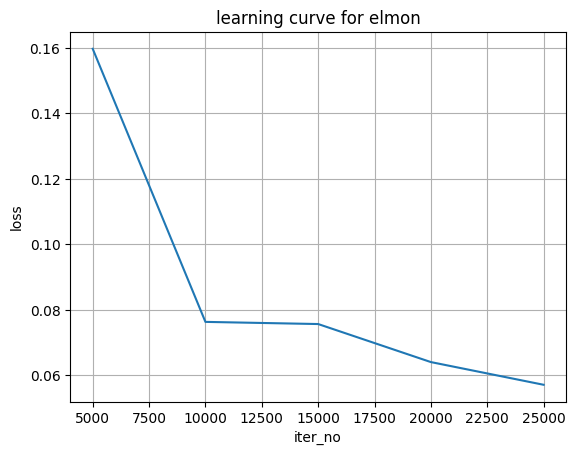

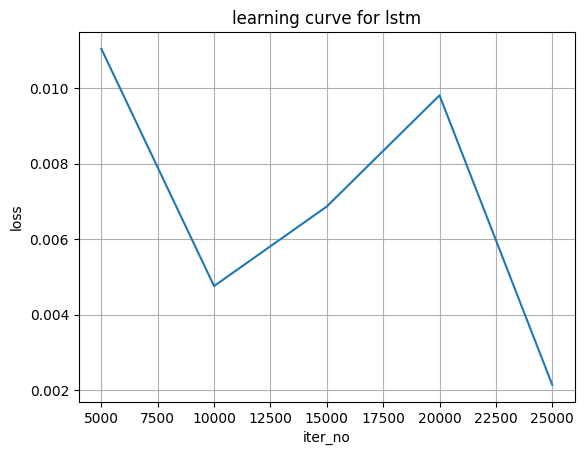

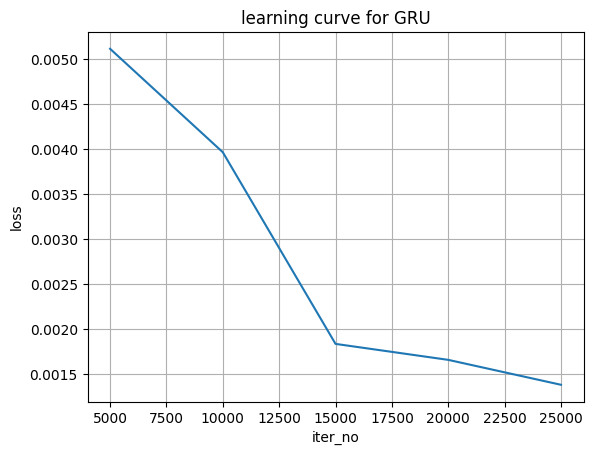

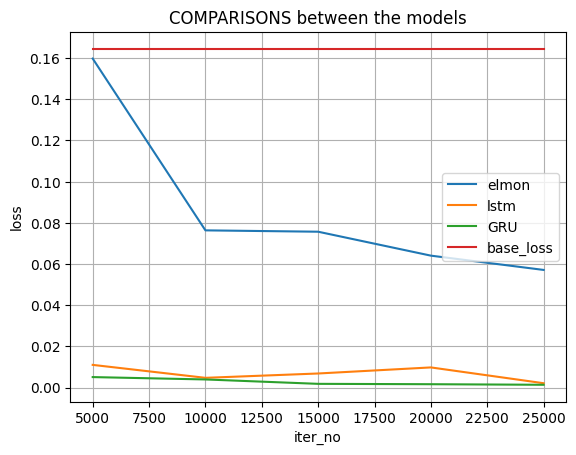

final performance can be seen by final loss incured by elmon tensor(0.0571, grad_fn=<DivBackward0>)
final performance can be seen by final loss incured by lstm tensor(0.0021, grad_fn=<DivBackward0>)
final performance can be seen by final loss incured by GRU tensor(0.0014, grad_fn=<DivBackward0>)
BASELINE
loss against the base line a baseline that always predicts a sum of 1-- tensor(0.1645)


<BarContainer object of 4 artists>

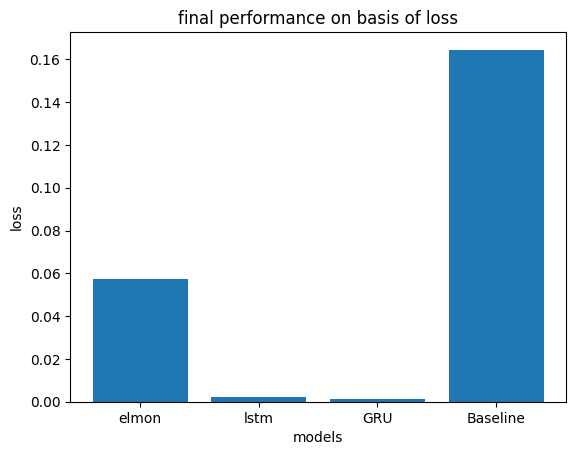

In [ ]:

#base_loss indicates the loss if baseline of 1 is always predicted on each test input
base_loss=0
for i in range(0,len(testdataset)):
 base_loss=base_loss+(1-testdataset[i][1])**2

base_loss_unchange=[base_loss/2500 for i in iterations_elmon]


plt.title("learning curve for elmon")
plt.xlabel("iter_no")
plt.ylabel("loss")
plt.grid()
plt.plot(iterations_elmon,losses_elmon)
plt.show()
plt.title("learning curve for lstm")
plt.xlabel("iter_no")
plt.ylabel("loss")
plt.grid()
plt.plot(iterations_lstm,losses_lstm)
plt.show()
plt.title("learning curve for GRU")
plt.xlabel("iter_no")
plt.ylabel("loss")
plt.grid()
plt.plot(iterations_GRU,losses_GRU)
plt.show()


plt.title("COMPARISONS between the models")
plt.xlabel("iter_no")
plt.ylabel("loss")
plt.grid()
plt.plot(iterations_elmon,losses_elmon)
plt.plot(iterations_lstm,losses_lstm)
plt.plot(iterations_GRU,losses_GRU)
plt.plot(iterations_elmon,base_loss_unchange)
plt.legend(['elmon','lstm','GRU','base_loss'])
plt.show()
#final accuracy
final_loss_elmon=0
final_loss_lstm=0
final_loss_GRU=0


for i in range(0,len(testdataset)):
  final_loss_elmon=final_loss_elmon+(elmon(testdataset[i],elmon_Wxh,elmon_Whh,elmon_Wyh,elmon_bh,elmon_by,elmon_h)-testdataset[i][1])**2


for i in range(0,len(testdataset)):
 final_loss_GRU=final_loss_GRU+(GRU(GRU_Wz,GRU_Wr,GRU_Wh,GRU_h,GRU_Wy,GRU_by,testdataset[i])-testdataset[i][1])**2

for i in range(0,len(testdataset)):
 final_loss_lstm=final_loss_lstm+(lstm(C,h,Wc,Wi,Wo,Wf,bc,bi,bo,bf,Wy,by,testdataset[i])-testdataset[i][1])**2
  
print("final performance can be seen by final loss incured by elmon",final_loss_elmon/len(testdataset))
print("final performance can be seen by final loss incured by lstm",final_loss_lstm/len(testdataset))
print("final performance can be seen by final loss incured by GRU",final_loss_GRU/len(testdataset))

#avg_model_loss means average loss incured by the model on the testdataset data sample
avg_GRU_loss=(final_loss_GRU.detach().numpy())/len(testdataset)
avg_elmon_loss=(final_loss_elmon.detach().numpy())/len(testdataset)
avg_lstm_loss=(final_loss_lstm.detach().numpy())/len(testdataset)
avg_baseline_loss=(base_loss.detach().numpy())/len(testdataset)

print("BASELINE")
print("loss against the base line a baseline that always predicts a sum of 1--",base_loss/len(testdataset))

plt.title("final performance on basis of loss")
plt.xlabel("models")
plt.ylabel("loss")
plt.bar(['elmon','lstm','GRU','Baseline'],[avg_elmon_loss,avg_lstm_loss,avg_GRU_loss,avg_baseline_loss])

(As suggested by sir in the comments)Accuracy on the basis of some epsilon as the exact predictions can not be expected if the task is regression.
Accuracy=(no of correct predictions)/(total no of predictions)=(no of almost correctly memorised inputs)/(total no of predictions)


elmon_accuracy:) 33.48 %
lstm_accuracy:) 97.6 %
baseline_accuracy:) 0.007632 %
GRU_accuracy:) 98.8 %


<BarContainer object of 4 artists>

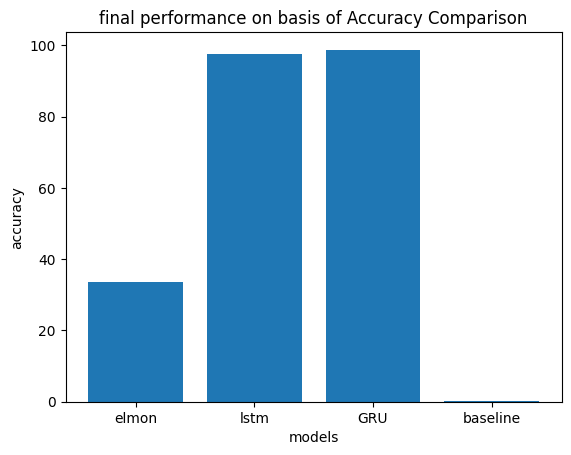

In [ ]:
epsilon=0.1

#corr_pre_elmon denotes correct predictions by elmon
corr_pre_elmon=0
corr_pre_lstm=0
corr_pre_GRU=0
corr_pre_base_line=0


for i in range(0,len(testdataset)):
  if abs(testdataset[i][1]-elmon(testdataset[i],elmon_Wxh,elmon_Whh,elmon_Wyh,elmon_bh,elmon_by,elmon_h))<=epsilon:
     corr_pre_elmon=corr_pre_elmon+1
print("elmon_accuracy:)",(corr_pre_elmon/len(testdataset))*100,"%")
elmon_accuracy=(corr_pre_elmon/len(testdataset))*100
for i in range(0,len(testdataset)):
  if abs(testdataset[i][1]-lstm(C,h,Wc,Wi,Wo,Wf,bc,bi,bo,bf,Wy,by,testdataset[i]))<=epsilon:
     corr_pre_lstm=corr_pre_lstm+1
print("lstm_accuracy:)",(corr_pre_lstm/len(testdataset))*100,"%")
lstm_accuracy=(corr_pre_lstm/len(testdataset))*100

for i in range(0,len(testdataset)):
  if abs(testdataset[i][1]-GRU(GRU_Wz,GRU_Wr,GRU_Wh,GRU_h,GRU_Wy,GRU_by,testdataset[i]))<=epsilon:
     corr_pre_GRU=corr_pre_GRU+1

for i in range(0,len(testdataset)):
  if abs(testdataset[i][1]-1)<=epsilon:
    corr_pre_base_line=corr_pre_base_line+1
baseline_accuracy=corr_pre_base_line/len(testdataset)
print("baseline_accuracy:)",(baseline_accuracy/len(testdataset))*100,"%")

print("GRU_accuracy:)",(corr_pre_GRU/len(testdataset))*100,"%")
GRU_accuracy=(corr_pre_GRU/len(testdataset))*100
plt.xlabel('models')
plt.ylabel('accuracy')
plt.title("final performance on basis of Accuracy Comparison")
plt.bar(['elmon','lstm','GRU','baseline'],[elmon_accuracy,lstm_accuracy,GRU_accuracy,baseline_accuracy])